In [ ]:
!pip install audiomentations
!pip install pyroomacoustics
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from PIL import Image
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, Gain, PitchShift, RoomSimulator
from tqdm import tqdm
import tensorflow as tf
import IPython.display as ipd

In [2]:
metadata = pd.read_csv('/content/drive/MyDrive/ESC-50-master/meta/esc50.csv')
metadata

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [3]:
#set aside 20% of images for testing, ensuring that the dataset is balanced by stratified sampling
test_df = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(8))
train_df = metadata[~metadata.isin(test_df)].dropna()

train_audio = []
train_labels = []
test_audio = []
test_labels = []

for i in tqdm(train_df.index):
  filename = train_df['filename'][i]
  label = train_df['target'][i]
  y,sr = librosa.load('/content/drive/MyDrive/ESC-50-master/audio/'+filename)
  train_audio.append(y)
  train_labels.append(label)

for i in tqdm(test_df.index):
  filename = test_df['filename'][i]
  label = test_df['target'][i]
  y,sr = librosa.load('/content/drive/MyDrive/ESC-50-master/audio/'+filename)
  test_audio.append(y)
  test_labels.append(label)


100%|██████████| 400/400 [01:05<00:00,  6.08it/s]


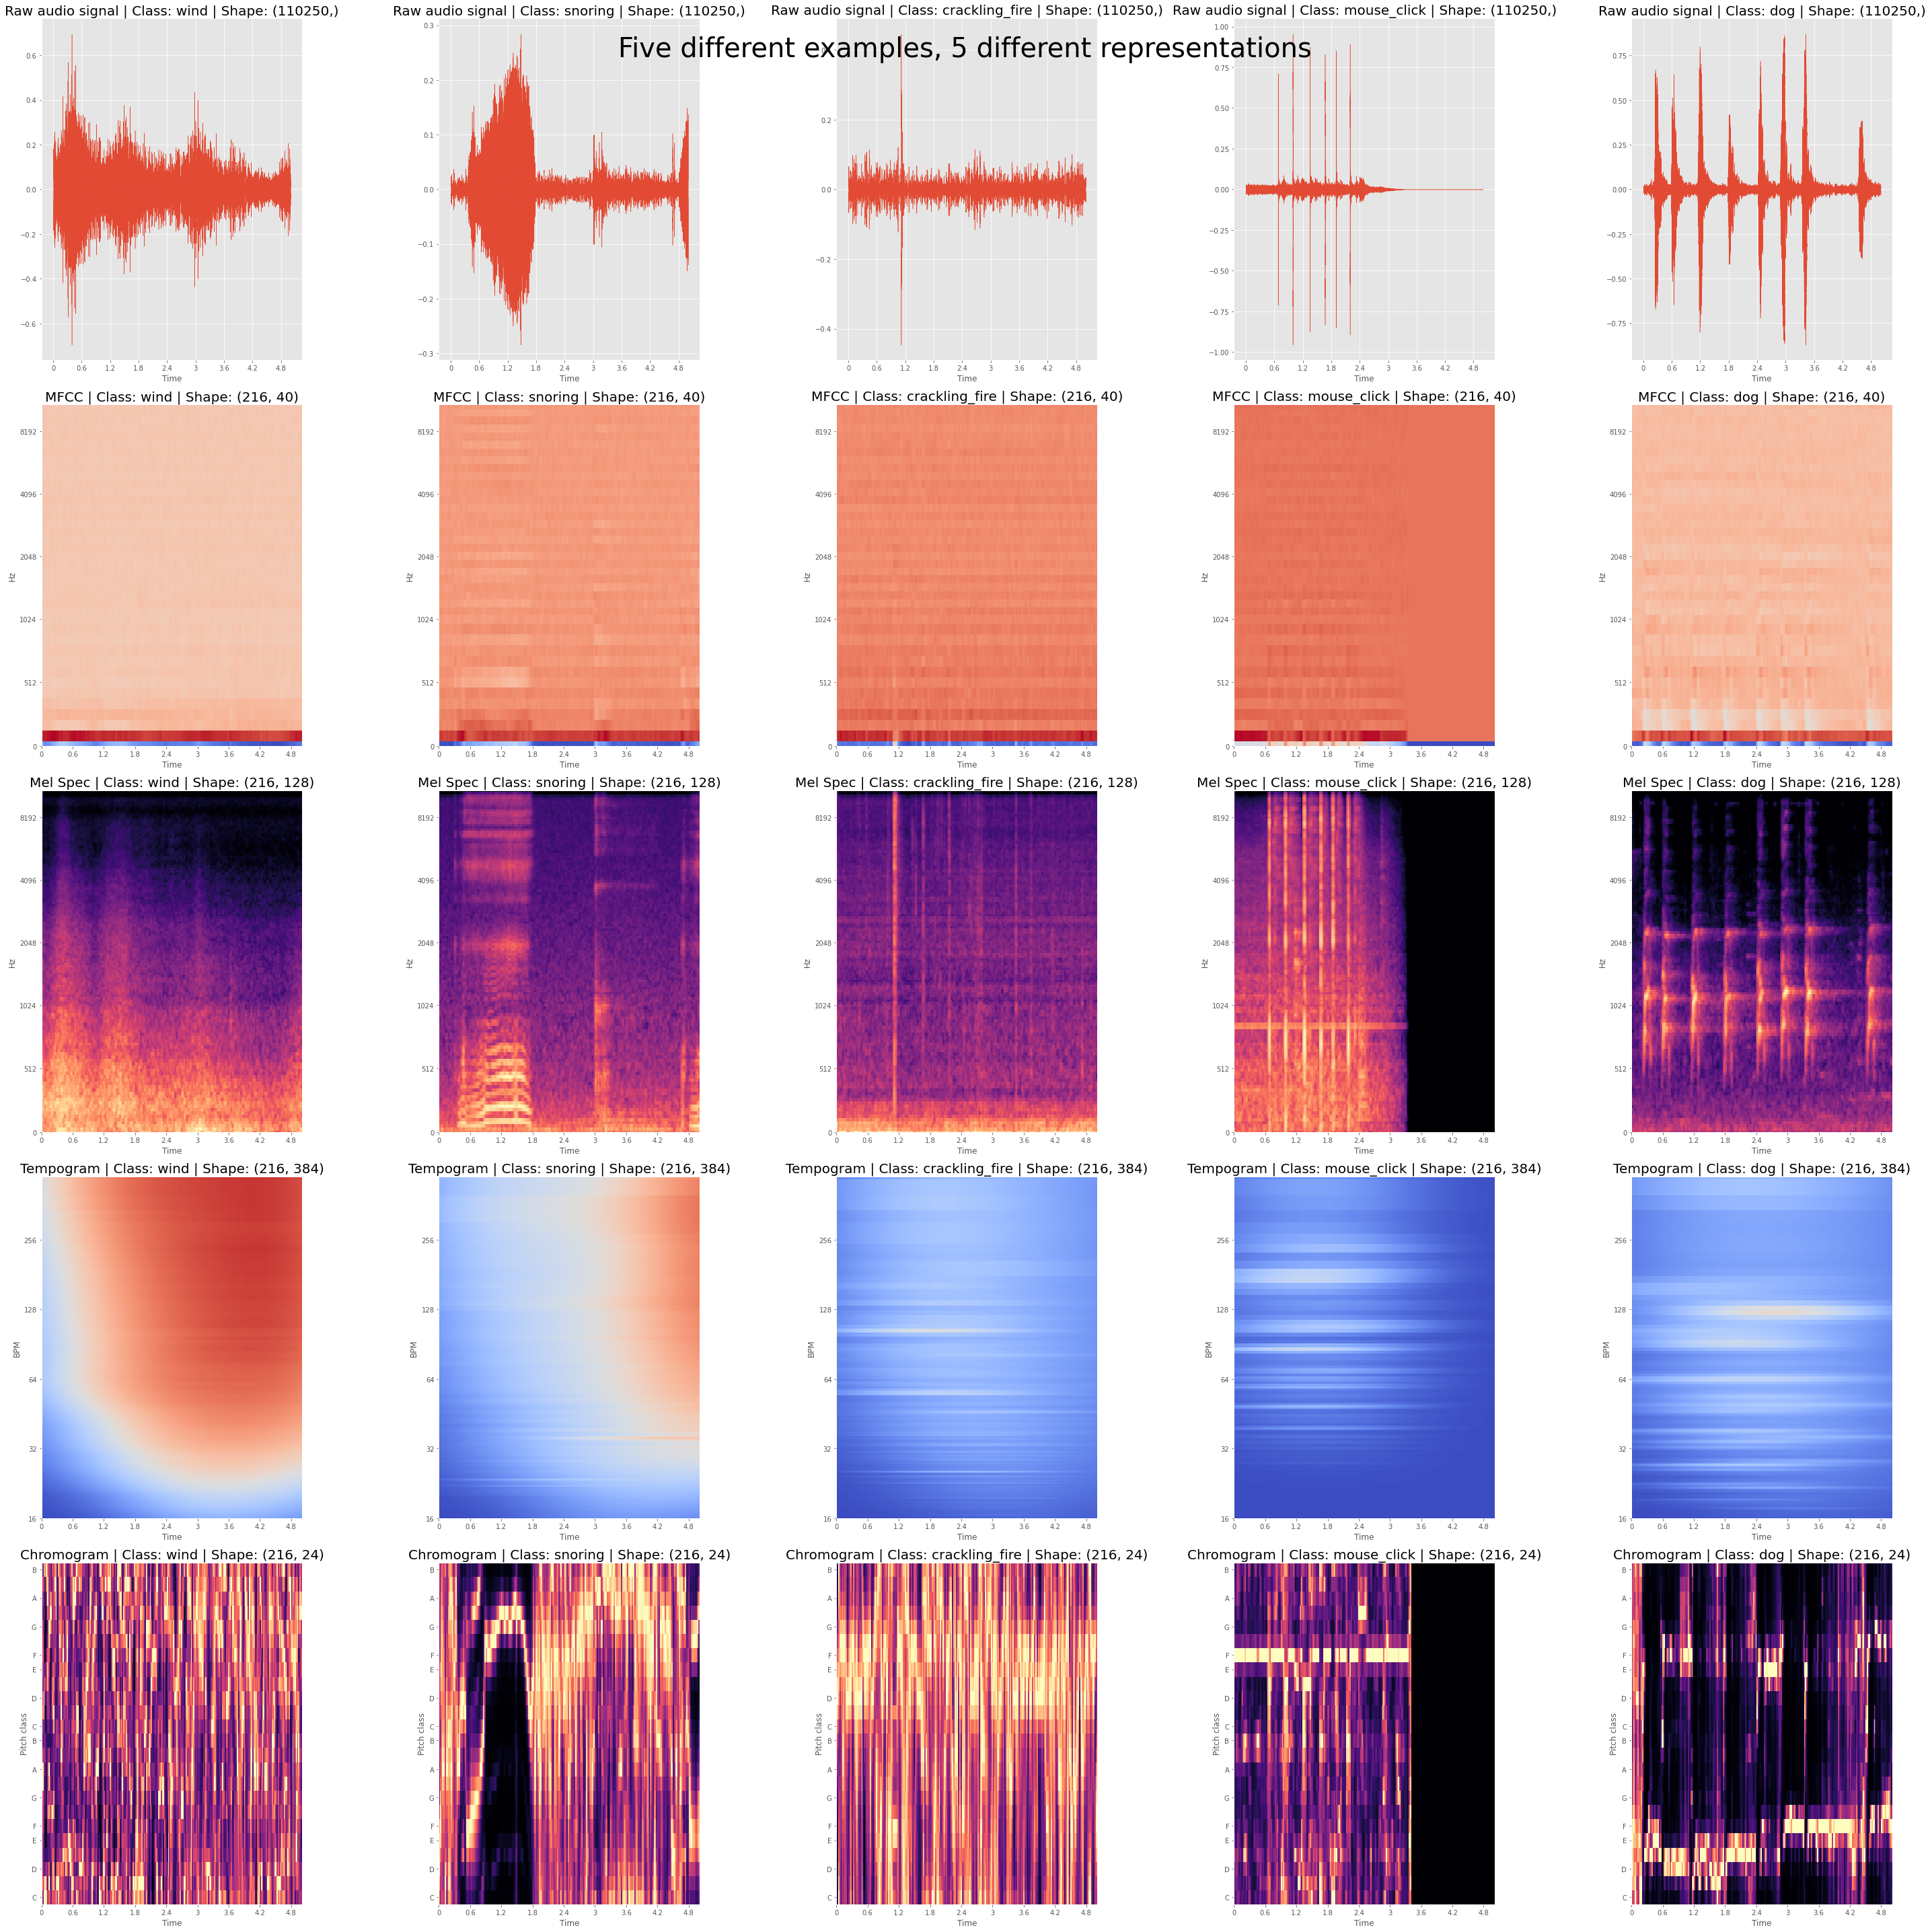

In [5]:
samples = metadata.sample(5)[['filename','category']]
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(40,40))
for i, idx in enumerate(samples.index):
    #load the audio file and grab the category
    filename = '/content/drive/MyDrive/ESC-50-master/audio/'+metadata['filename'][idx]
    category = metadata['category'][idx]
    y, sr = librosa.load(filename)
    #get the melspec in db before plotting
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    #get the mfccs
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_fft=2048, hop_length=512, n_mfcc=40)
    #get the tempogram
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length= 512, norm=None)
    #get the chromagram
    chromagram = librosa.feature.chroma_stft(y=y,sr=sr,n_fft=2048,hop_length=512, n_chroma=24)
    #plot the wave
    librosa.display.waveshow(y,sr=sr,ax=ax[0][i])
    #plot the mfcc
    librosa.display.specshow(mfcc, sr=sr, ax=ax[1][i],y_axis='mel', x_axis='time')
    #plot the melspec
    librosa.display.specshow(melspec,sr=sr,ax=ax[2][i], y_axis='mel', x_axis='time')
    #plot the tempogram
    librosa.display.specshow(tempogram, sr=sr, hop_length=512,x_axis='time', y_axis='tempo',ax=ax[3][i])
    #plot the chromagram
    librosa.display.specshow(chromagram, sr=sr, hop_length=512,x_axis='time', y_axis='chroma',ax=ax[4][i])
    ax[0][i].set_title(f"Raw audio signal | Class: {category} | Shape: {y.shape}",fontsize=20)
    ax[1][i].set_title(f"MFCC | Class: {category} | Shape: {mfcc.T.shape}",fontsize=20)
    ax[2][i].set_title(f"Mel Spec | Class: {category} | Shape: {melspec.T.shape}",fontsize=20)
    ax[3][i].set_title(f"Tempogram | Class: {category} | Shape: {tempogram.T.shape}",fontsize=20)
    ax[4][i].set_title(f"Chromogram | Class: {category} | Shape: {chromagram.T.shape}",fontsize=20)

fig.suptitle('Five different examples, 5 different representations\n\n',fontsize=40)
fig.tight_layout()
fig.savefig('/content/drive/MyDrive/5_examples.png')

In [4]:
audio_augment = Compose([
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.15, p=0),
        #PitchShift(min_semitones=-6, max_semitones=6, p=1),
        TimeStretch(min_rate=.75, max_rate=1.25,p=1),
        #Gain(min_gain_in_db=12, max_gain_in_db=12, p=1),
        #RoomSimulator(p=1, leave_length_unchanged=True)
])

In [ ]:
#showing augmentation
import soundfile as sf
meow = metadata.query('category == "cat"').iloc[2]['filename']
y, sr = librosa.load('/content/drive/MyDrive/ESC-50-master/audio/'+meow)
ipd.Audio(y, rate=sr)
augmented = audio_augment(samples=y, sample_rate=sr)
ipd.Audio(augmented, rate=sr)
sf.write('/content/drive/MyDrive/meow_no_aug.wav', y, sr)
sf.write('/content/drive/MyDrive/meow_aug.wav', augmented, sr)

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#callbacks
rlronp=ReduceLROnPlateau(monitor="val_accuracy",factor=0.5, patience=2, verbose=1)
estop=EarlyStopping(monitor="val_accuracy", patience=6, verbose=1, restore_best_weights=True)

def build_model(input_shape):
  # create the model
  model = Sequential()

  # add layers
  model.add(BatchNormalization(axis=1, input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation="softmax"))

  # compile the model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [7]:
def run_experiment(make_spec, augment=0):

  images_train = np.array([make_spec(clip,sr) for clip in train_audio])
  images_test =  np.array([make_spec(clip,sr) for clip in test_audio])

  num_augmented = int(len(train_audio)*augment)
  if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([make_spec(audio_augment(samples=clip, sample_rate=sr),sr) for clip in train_audio[:num_augmented]])
    images_train = np.concatenate((images_train, augmented_img))


  #expected shape (num_examples, spec freq range, spec time, 1)
  shape_train = (len(images_train), images_train[0].shape[0], images_train[0].shape[1], 1)
  shape_test = (len(images_test), images_train[0].shape[0], images_train[0].shape[1], 1)
  images_train = np.resize(images_train, shape_train)
  images_test = np.resize(images_test, shape_test)

  labels_train = np.array(train_labels+train_labels[:num_augmented])
  labels_test = np.array(test_labels)

  model = build_model(shape_train[1:])

  model.summary()

  history = model.fit(images_train, labels_train, epochs=40, validation_data=(images_test,labels_test), callbacks=[rlronp,estop])

  return history, estop

In [8]:
def plot_curves(history, estop=None):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_ylim([0, 1])
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')

  if estop:
    best_epoch = estop.stopped_epoch-estop.patience
    ax[0].plot(best_epoch, history.history['accuracy'][best_epoch], marker='*', color='gold',ms=10)
    ax[0].plot(best_epoch, history.history['val_accuracy'][best_epoch], marker='*', color='gold',ms=10)
    ax[1].plot(best_epoch, history.history['loss'][best_epoch], marker='*', color='gold',ms=10)
    ax[1].plot(best_epoch, history.history['val_loss'][best_epoch], marker='*', color='gold',ms=10)
    ax[0].legend(['Train', 'Test', 'Best weights'], loc='upper left')
    ax[1].legend(['Train', 'Validation','Best weights'], loc='upper left')
  else:
    ax[0].legend(['Train', 'Test'], loc='upper left')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
  return fig

In [9]:
# Experiment #1: Mel Spectrograms, No augmentation

def generate_mel_spectrogram(y,sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

#history_ex_1, estop_ex_1 = run_experiment(generate_mel_spectrogram, augment=0)
#plot_curves(history_ex_1, estop=estop_ex_1).show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 128, 216, 1)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 216, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 108, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 108, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 54, 128)      0         
 2D)                                                             
                                                      

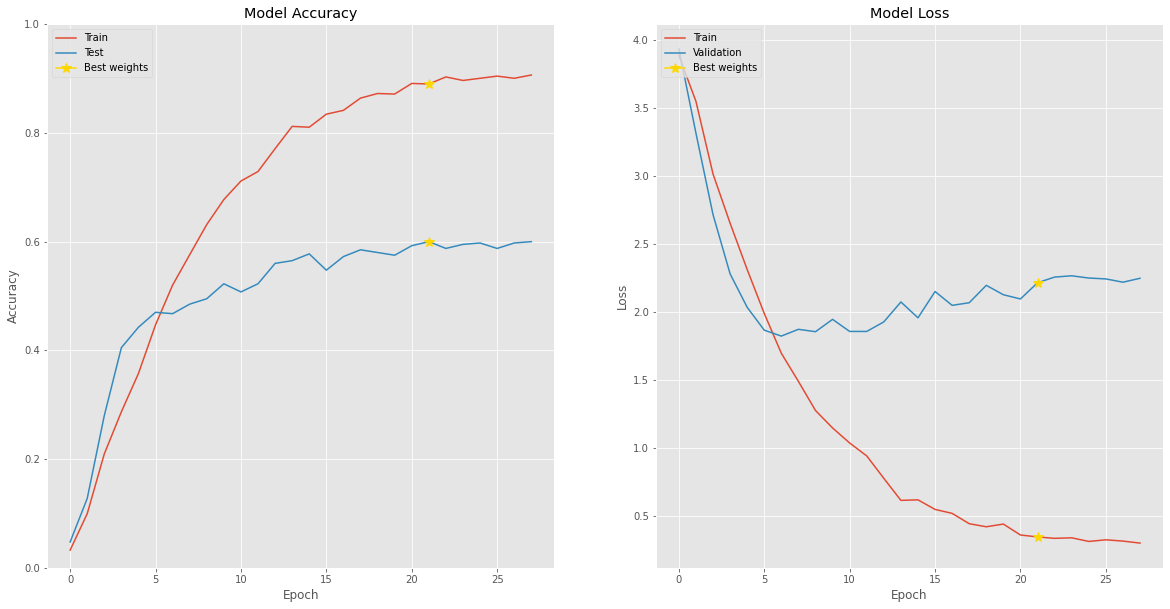

In [ ]:
history_ex_2, estop_ex_2 = run_experiment(generate_mel_spectrogram, augment=.25)

plot_curves(history_ex_2, estop=estop_ex_2).show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 128, 216, 1)      512       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 216, 64)      640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 108, 64)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 108, 128)      73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 54, 128)      0         
 2D)                                                             
                                                      

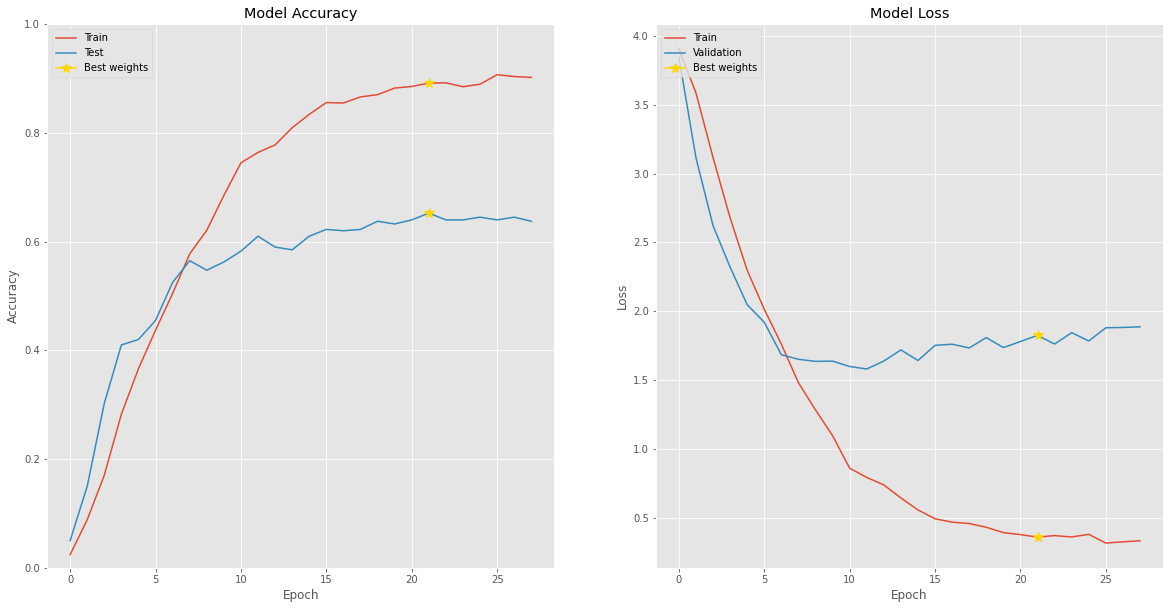

In [ ]:
history_ex_3, estop_ex_3 = run_experiment(generate_mel_spectrogram, augment=.5)

plot_curves(history_ex_3, estop=estop_ex_3).show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 128, 216, 1)      512       
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 216, 64)      640       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 108, 128)      73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 54, 128)      0         
 g2D)                                                            
                                                      

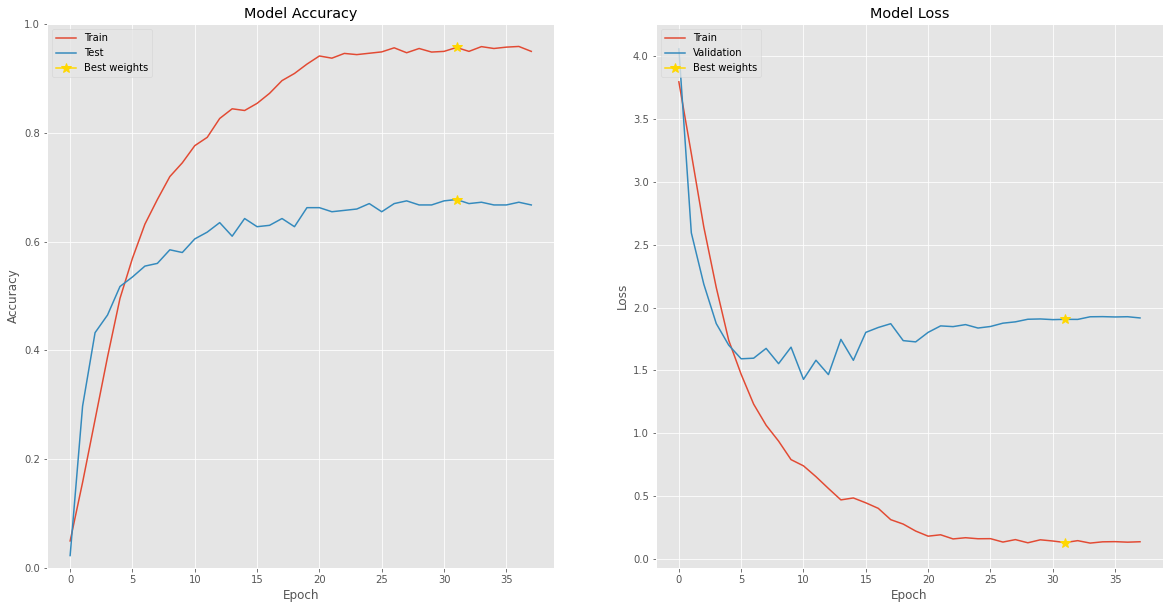

In [ ]:
history_ex_4, estop_ex_4 = run_experiment(generate_mel_spectrogram, augment=1)

plot_curves(history_ex_4, estop=estop_ex_4).show()

In [10]:
def generate_mfcc(y,sr):
  return librosa.feature.mfcc(y=y,sr=sr, n_fft=2048, hop_length=512, n_mfcc=20)

#mfcc_ex_5, estop_ex_5 = run_experiment(generate_mfcc, augment=0)
#plot_curves(mfcc_ex_5, estop=estop_ex_5).show()

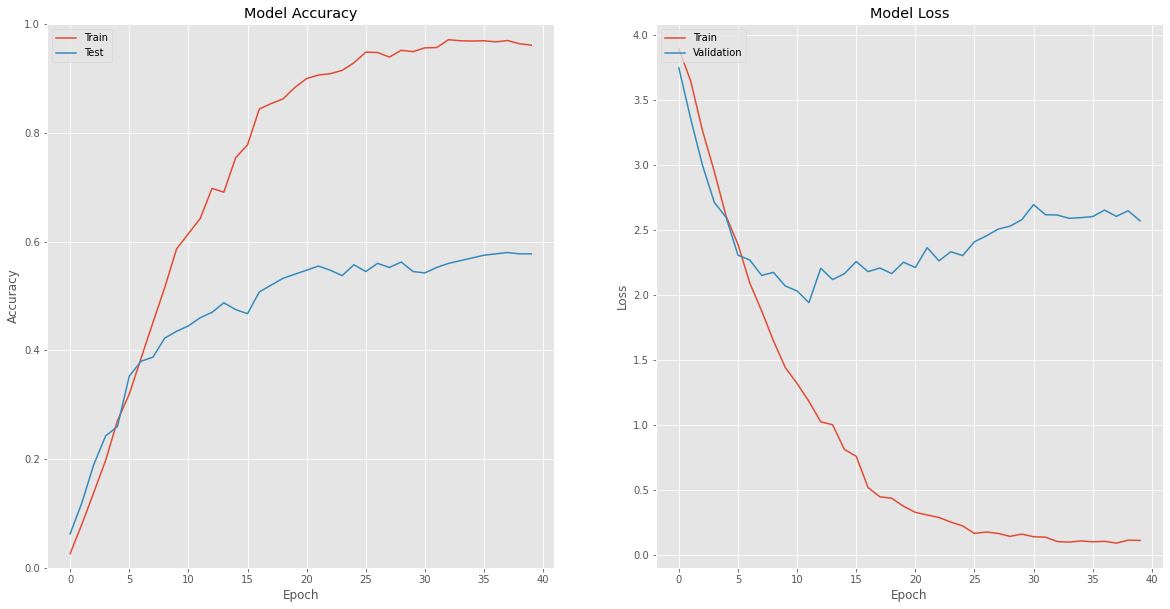

In [ ]:
#mfcc_ex_6, estop_ex_6 = run_experiment(generate_mfcc, augment=.25)

plot_curves(mfcc_ex_6).show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 20, 216, 1)       80        
 hNormalization)                                                 
                                                                 
 conv2d_32 (Conv2D)          (None, 20, 216, 64)       640       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 10, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 10, 108, 128)      73856     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 5, 54, 128)       0         
 g2D)                                                            
                                                      

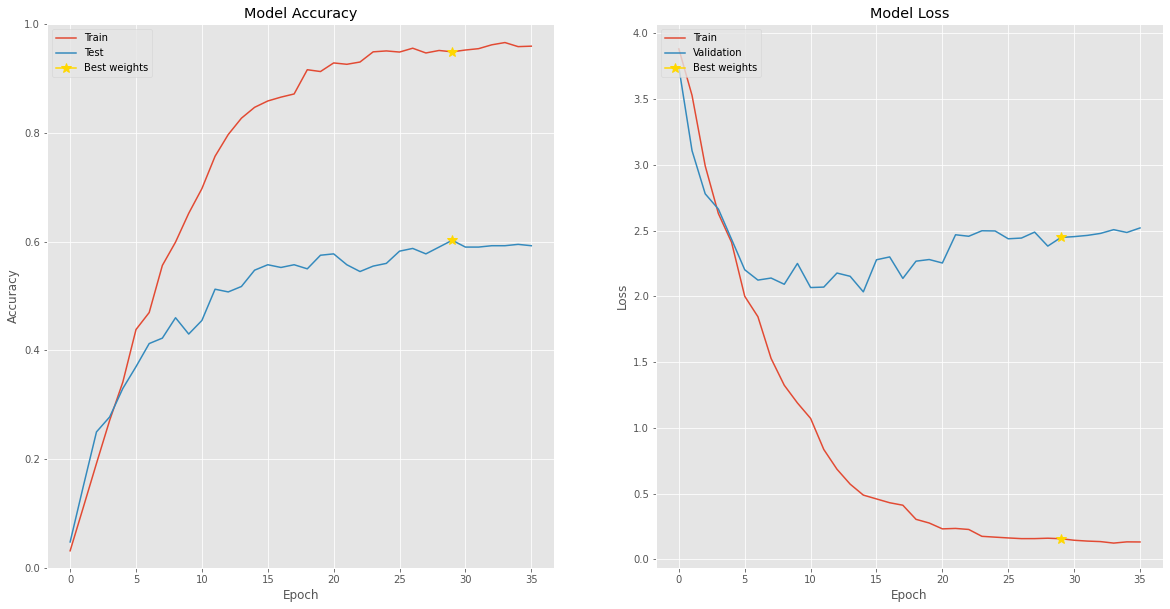

In [ ]:
mfcc_ex_7, estop_ex_7 = run_experiment(generate_mfcc, augment=.5)

plot_curves(mfcc_ex_7, estop=estop_ex_7).show()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 20, 216, 1)       80        
 hNormalization)                                                 
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 216, 64)       640       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 10, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 10, 108, 128)      73856     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 5, 54, 128)       0         
 g2D)                                                            
                                                      

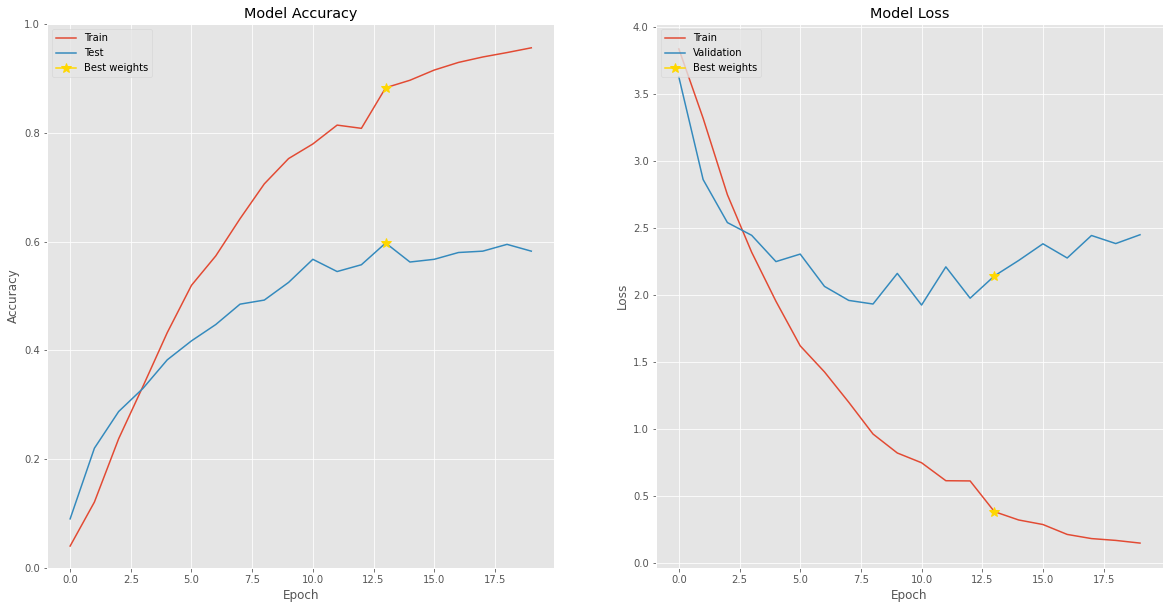

In [ ]:
mfcc_ex_8, estop_ex_8 = run_experiment(generate_mfcc, augment=1)

plot_curves(mfcc_ex_8, estop=estop_ex_8).show()

In [11]:
def generate_tempogram(y,sr):
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length= 512, norm=None)
    return tempogram

#history_ex_9, estop_ex_9 = run_experiment(generate_tempogram, augment=0)
#plot_curves(history_ex_9, estop=estop_ex_9).show()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_11 (Bat  (None, 384, 216, 1)      1536      
 chNormalization)                                                
                                                                 
 conv2d_44 (Conv2D)          (None, 384, 216, 64)      640       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 192, 108, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 96, 54, 128)      0         
 g2D)                                                            
                                                     

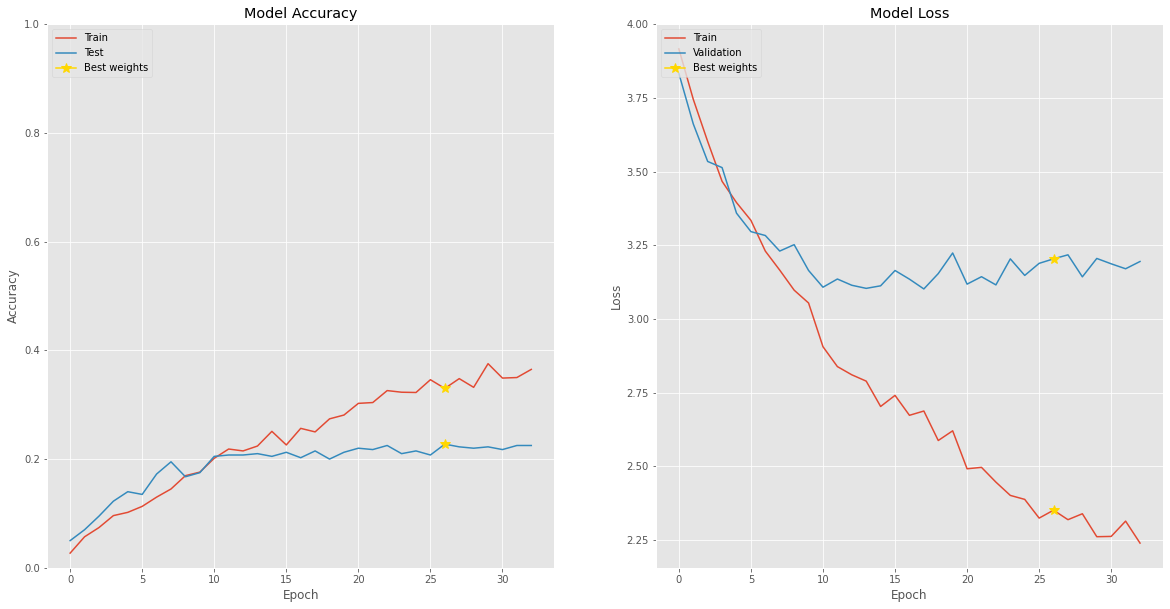

In [ ]:
history_ex_10, estop_ex_10 = run_experiment(generate_tempogram, augment=.25)
plot_curves(history_ex_10, estop=estop_ex_10).show()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 384, 216, 1)      1536      
 chNormalization)                                                
                                                                 
 conv2d_48 (Conv2D)          (None, 384, 216, 64)      640       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 192, 108, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 96, 54, 128)      0         
 g2D)                                                            
                                                     

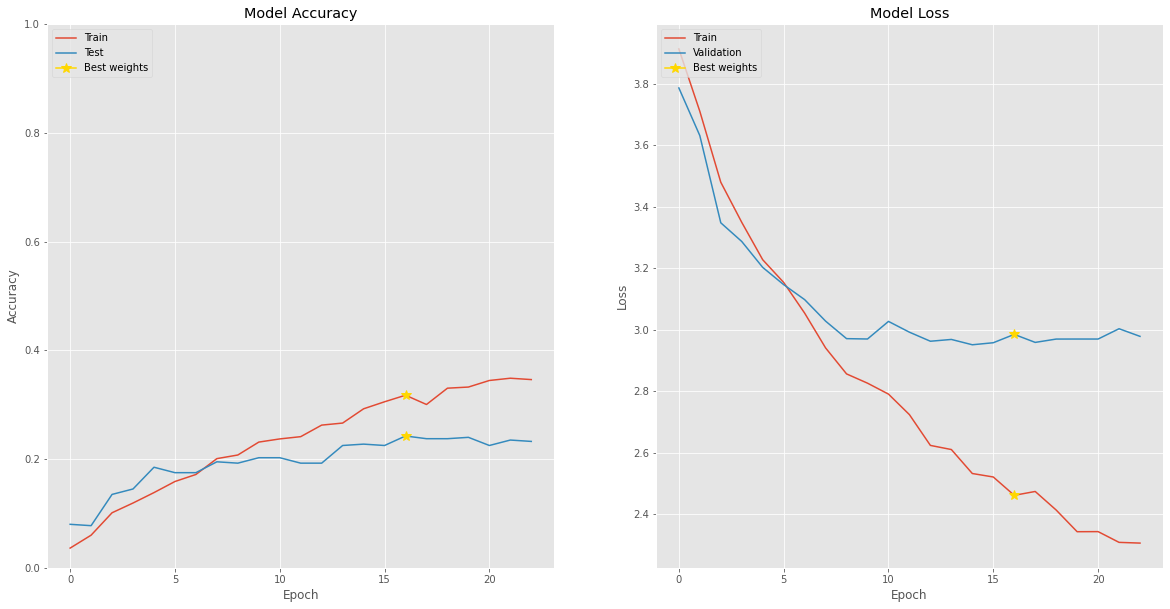

In [ ]:
history_ex_11, estop_ex_11 = run_experiment(generate_tempogram, augment=.5)
plot_curves(history_ex_11, estop=estop_ex_11).show()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_13 (Bat  (None, 384, 216, 1)      1536      
 chNormalization)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 384, 216, 64)      640       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 192, 108, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 96, 54, 128)      0         
 g2D)                                                            
                                                     

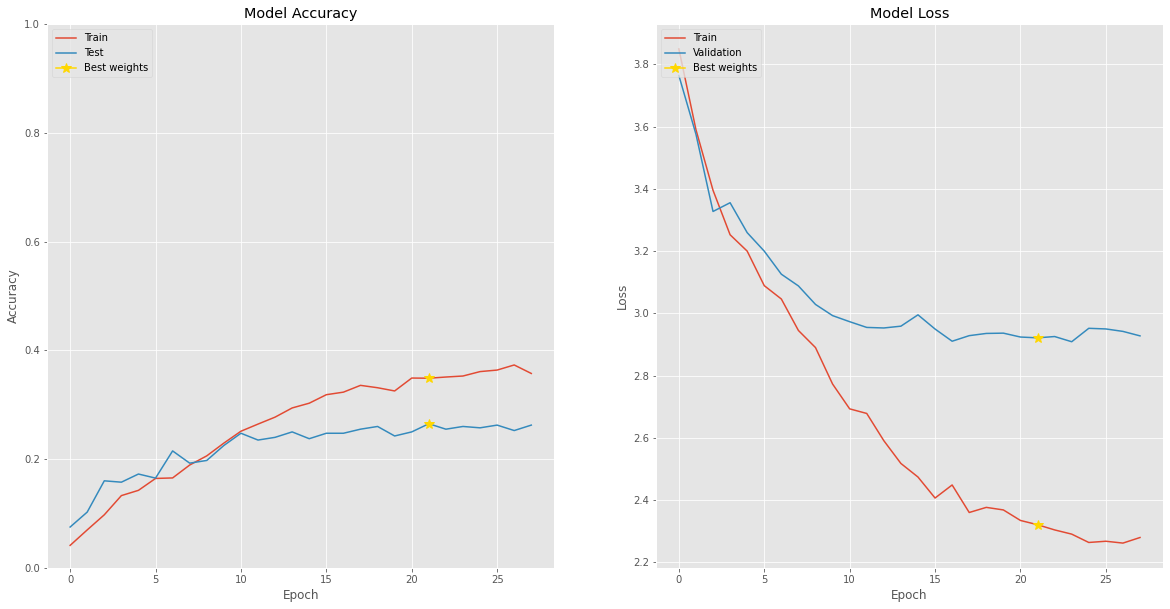

In [ ]:
history_ex_12, estop_ex_12 = run_experiment(generate_tempogram, augment=1)
plot_curves(history_ex_12, estop=estop_ex_12).show()


In [12]:
def generate_chromagram(y,sr):
  return librosa.feature.chroma_stft(y=y,sr=sr,n_fft=2048,hop_length=512, n_chroma=24)

#history_ex_13, estop_ex_13 = run_experiment(generate_chromagram, augment=0)
#plot_curves(history_ex_13, estop=estop_ex_13).show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 24, 216, 1)       96        
 chNormalization)                                                
                                                                 
 conv2d_60 (Conv2D)          (None, 24, 216, 64)       640       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 12, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 12, 108, 128)      73856     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 6, 54, 128)       0         
 g2D)                                                            
                                                     

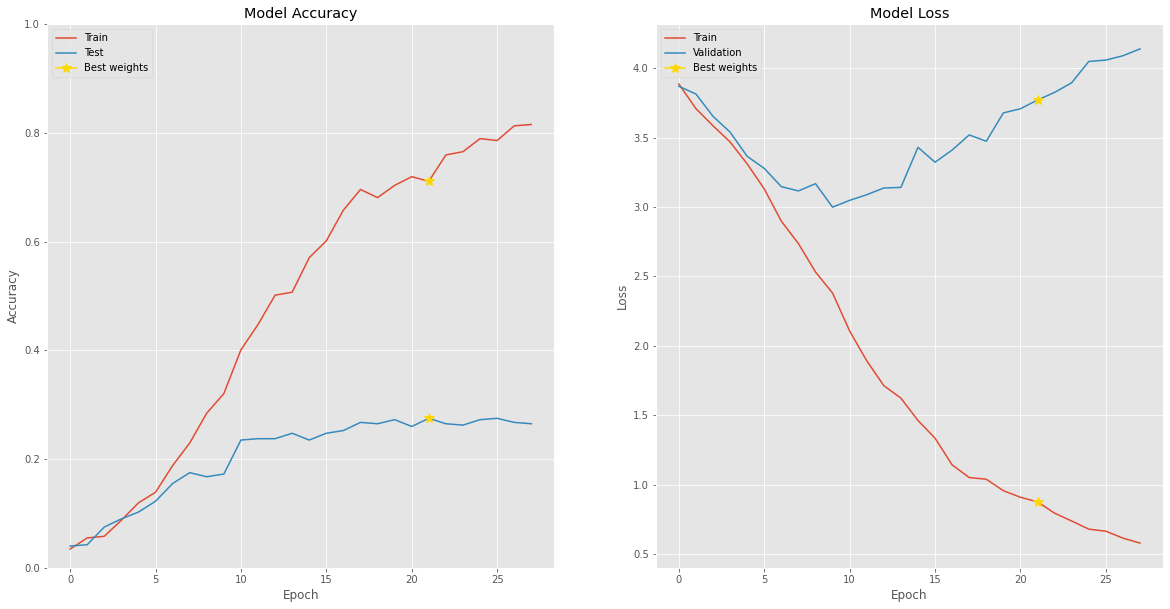

In [ ]:
history_ex_14, estop_ex_14 = run_experiment(generate_chromagram, augment=.25)
plot_curves(history_ex_14, estop=estop_ex_14).show()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Bat  (None, 24, 216, 1)       96        
 chNormalization)                                                
                                                                 
 conv2d_64 (Conv2D)          (None, 24, 216, 64)       640       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 12, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 12, 108, 128)      73856     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 6, 54, 128)       0         
 g2D)                                                            
                                                     

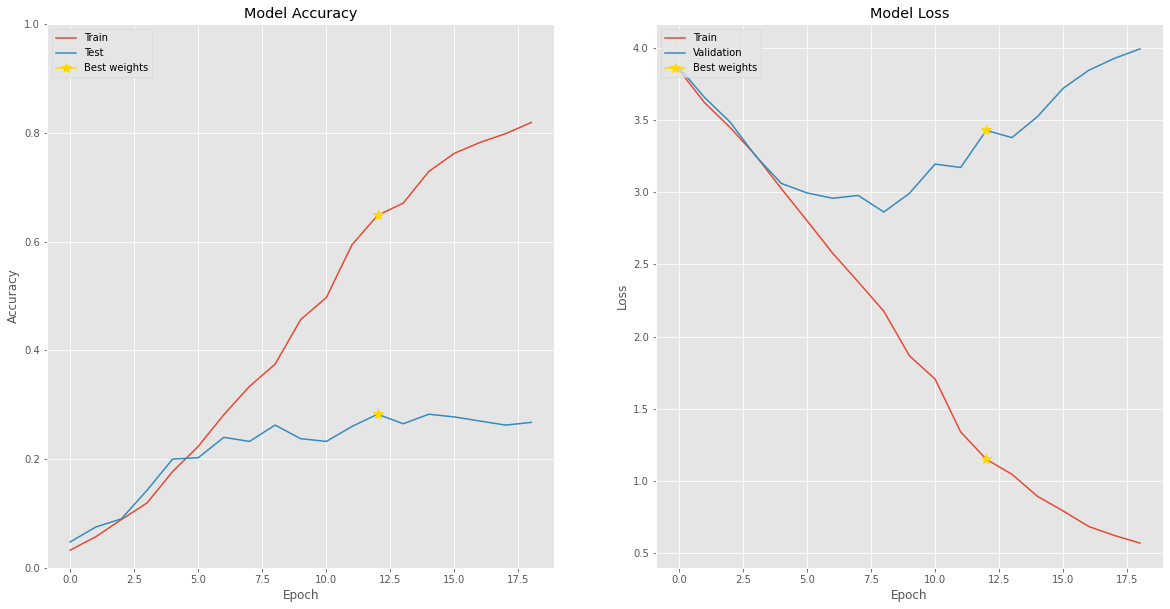

In [ ]:
history_ex_15, estop_ex_15 = run_experiment(generate_chromagram, augment=.5)
plot_curves(history_ex_15, estop=estop_ex_15).show()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_17 (Bat  (None, 24, 216, 1)       96        
 chNormalization)                                                
                                                                 
 conv2d_68 (Conv2D)          (None, 24, 216, 64)       640       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 12, 108, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 12, 108, 128)      73856     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 6, 54, 128)       0         
 g2D)                                                            
                                                     

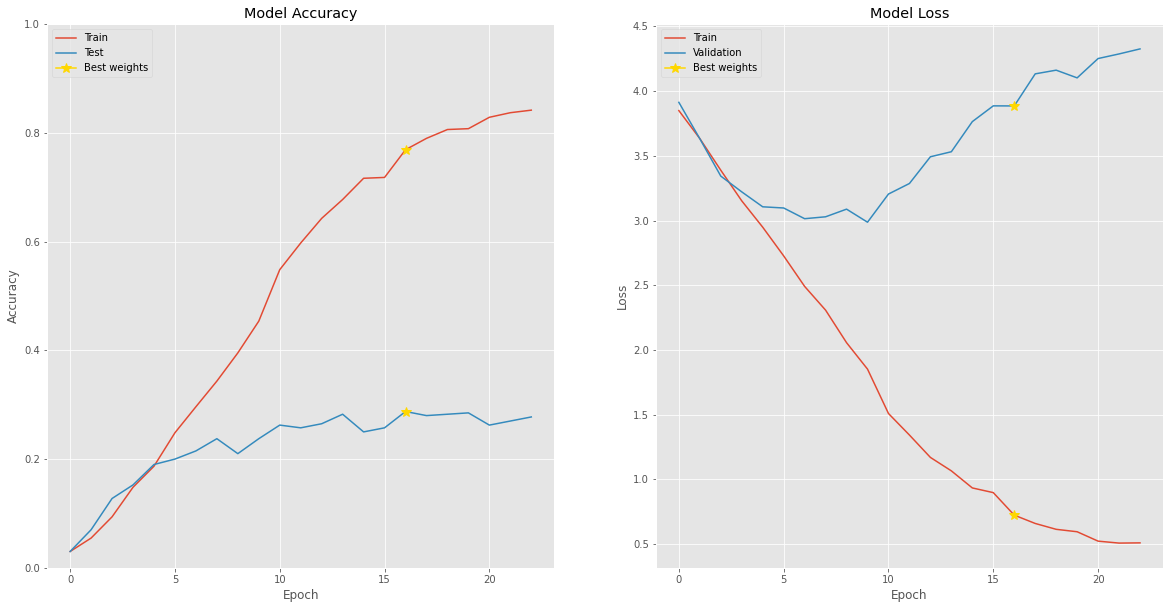

In [ ]:
history_ex_16, estop_ex_16 = run_experiment(generate_chromagram, augment=1)
plot_curves(history_ex_16, estop=estop_ex_16).show()

In [13]:
def make_stacked_spec(y,sr, spec_generators, scale = False):
  #make each spec
  specs = [spec_gen(y,sr) for spec_gen in spec_generators]
  #find the tallest height
  heights = np.array([spec.shape[0] for spec in specs])
  tallest = np.argmax(heights)
  stacked_specs = []
  for spec in specs:
    if scale:
      spec = np.array(Image.fromarray(spec).resize(specs[tallest].shape))
    else:
      #insert copies of the spec until it's over the tallest height
      while spec.shape[0] < specs[tallest].shape[0]:
        spec = np.vstack((spec,spec))
      #trim off the top edge
      spec = spec[0:specs[tallest].shape[0],:]
    stacked_specs.append(spec)
  # dstack each spec
  stacked_spec = np.dstack([spec for spec in stacked_specs])
  return stacked_spec

In [14]:
def run_experiment_stacked_specs(spec_generators, augment=0):

  num_channels = len(spec_generators)
  
  images_train = np.array([make_stacked_spec(clip,sr, spec_generators) for clip in train_audio])
  images_test =  np.array([make_stacked_spec(clip,sr, spec_generators) for clip in test_audio])

  num_augmented = int(len(train_audio)*augment)
  if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([make_stacked_spec(audio_augment(samples=clip, sample_rate=sr),sr, spec_generators) for clip in train_audio[:num_augmented]])
    images_train = np.concatenate((images_train, augmented_img))


  #expected shape (num_examples, spec freq range, spec time, 1)
  shape_train = (len(images_train), images_train[0].shape[0], images_train[0].shape[1], num_channels)
  shape_test = (len(images_test), images_train[0].shape[0], images_train[0].shape[1], num_channels)
  images_train = np.resize(images_train, shape_train)
  images_test = np.resize(images_test, shape_test)

  labels_train = np.array(train_labels+train_labels[:num_augmented])
  labels_test = np.array(test_labels)

  model = build_model(shape_train[1:])

  model.summary()

  history = model.fit(images_train, labels_train, epochs=40, validation_data=(images_test,labels_test), callbacks=[rlronp,estop])

  return history, estop

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 384, 216, 2)      1536      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 384, 216, 64)      1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 192, 108, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 54, 128)      0         
 2D)                                                             
                                                      

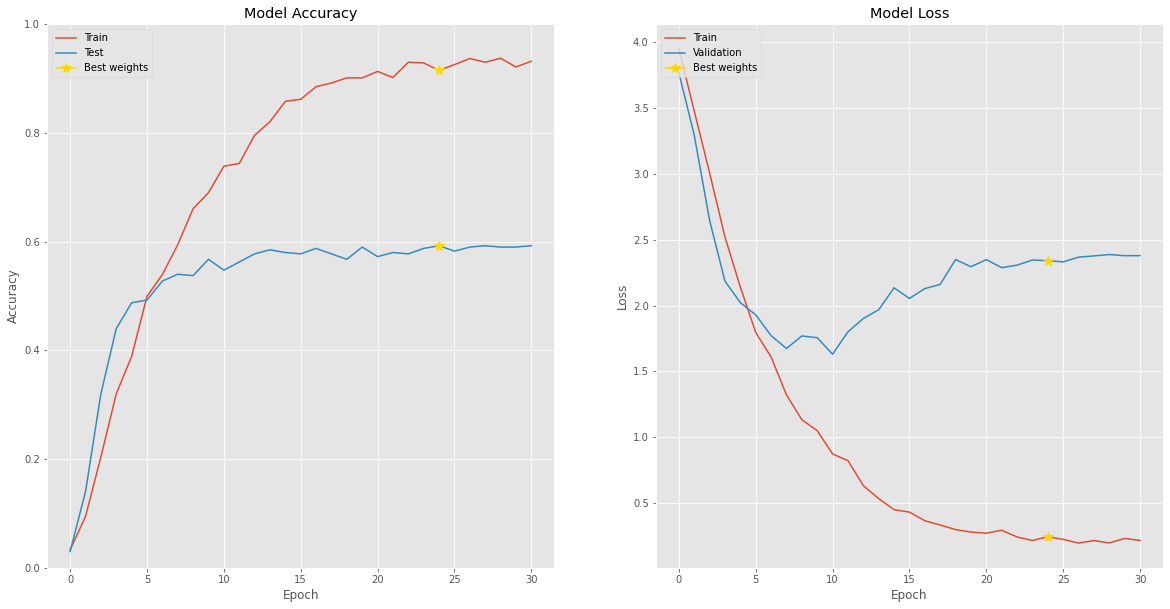

In [19]:
#melspecs and tempograms
history_ex_17, estop_ex_17 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_tempogram], augment=0)

plot_curves(history_ex_17, estop=estop_ex_17).show()

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequen

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 384, 216, 3)      1536      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 384, 216, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 108, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 54, 128)      0         
 2D)                                                             
                                                        

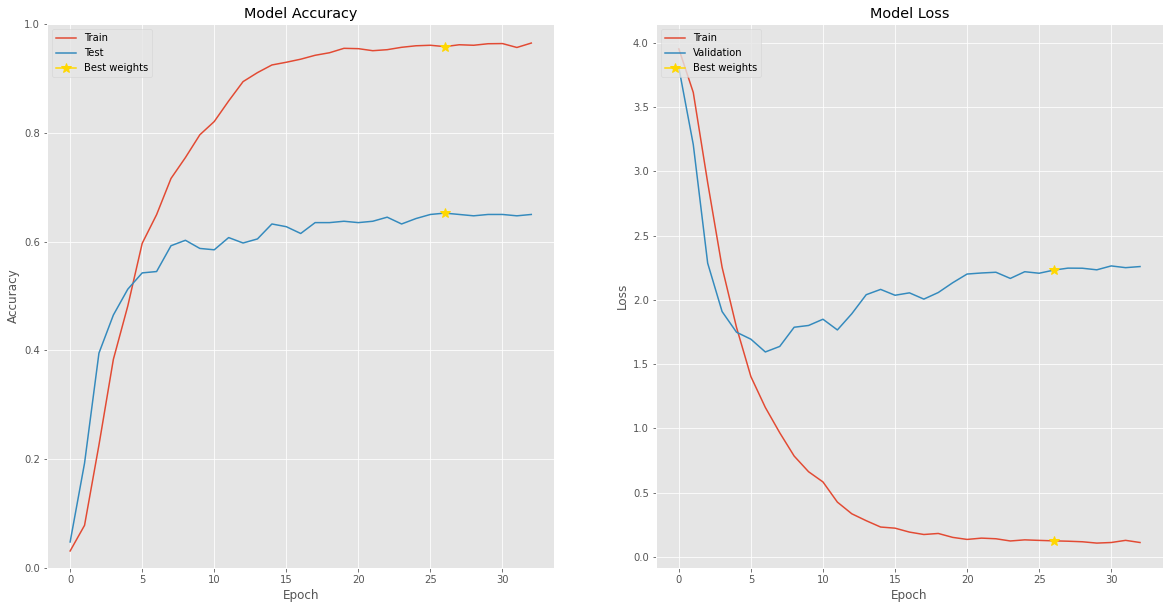

In [25]:
#melspecs, chromagrams, and  tempograms at 100% augmentation
history_ex_17, estop_ex_17 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_chromagram, generate_tempogram], augment=1)

plot_curves(history_ex_17, estop=estop_ex_17).show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 384, 216, 2)      1536      
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 384, 216, 64)      1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 192, 108, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 192, 108, 128)     73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 96, 54, 128)      0         
 2D)                                                             
                                                      

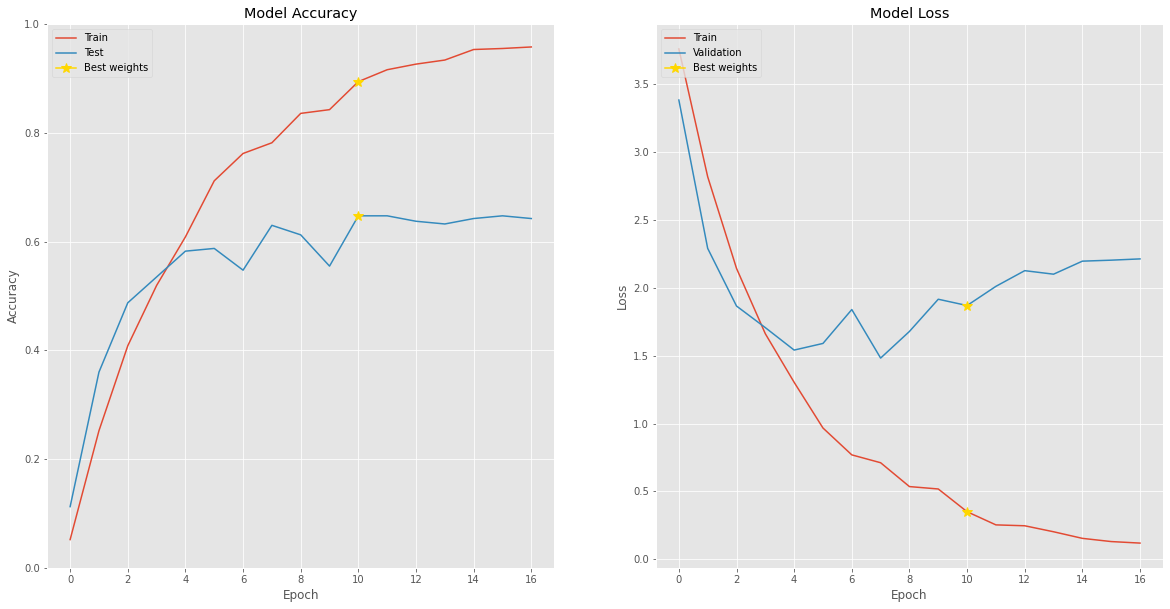

In [27]:
#melspecs and  tempograms at 100% augmentation
history_ex_18, estop_ex_18 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_tempogram], augment=1)

plot_curves(history_ex_18, estop=estop_ex_18).show()

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequen

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 216, 2)      512       
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 216, 64)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 108, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 108, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 54, 128)      0         
 2D)                                                             
                                                        

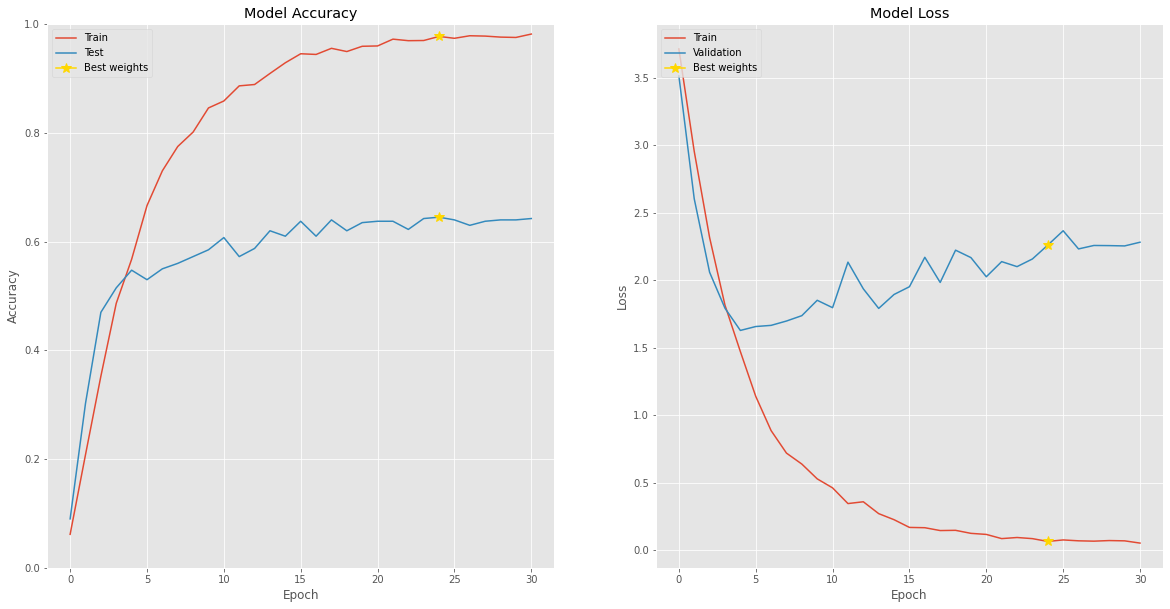

In [15]:
#melspecs and  chromagrams at 100% augmentation
history_ex_19, estop_ex_19 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_chromagram], augment=1)

plot_curves(history_ex_19, estop=estop_ex_19).show()